# The yield strength of the oceanic lithosphere
The yield strength envelope of the lithosphere is an estimate of how much stress the lithosphere can sustain as a function of depth. This estimate depends on a number of parameters of varying importance. Both brittle and ductile failure laws are used to evaluate the the yield strength.

In [1]:
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_yse(age,flags={}):
    '''
    Calls a C program on the command line to compute a yield strength
    profile of oceanic lithosphere given an age. Flags optional,
    default thermal model is plate cooling (Parsons n Sclater)
    '''
    outfile = open('out.temp','w')
    runcmd = './ocean_litho_yse' + ' ' + str(age) + ' '
    for flag, val in flags.items():
        runcmd = runcmd + str(flag) + ' ' + str(val) + ' '
    call(runcmd,shell=True,stdout=outfile)

In [5]:
def read_yse_data(yse_file):
    '''
    Reads the file written by compute_yse function,
    returns five parameters:
    depth, temperature (C), pressure, YS in tension and compression
    '''
    data = np.loadtxt(yse_file)
    z = -1*data[:,0]
    temp = data[:,1]
    pressure = data[:,2]
    strength_tension = data[:,3]
    strength_compress = data[:,4]
    strength_shear = data[:,5]
    return z,temp,pressure,strength_tension,strength_compress,strength_shear

In [7]:
def plot_YSE(ax,ysc,yst,ysh,z):
    ax.plot(ysc,z)
    ax.plot(yst,z)
    ax.plot(ysh,z)
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-20, 0)

## Flow laws
For a given stress state (i.e., tension or compression), different earth materials don't have dramatically different yield strength envelopes in the brittle failure regime. However, ductile flow, or the temperature at which ductile flow occurs, is more variable among earth materials.

For the following models, we use a dry olivine power law flow for the mantle. For the crust (fixed at 6 km thickness), we assign a slightly different flow law. There's a good argument for this (Chen and Morgan, 1990). We experiment using either a wet olivine flow law (Karato and Wu?) or a diabase flow law (citation needed) for the crust.

Here's what those different flow laws do to the YSE for a fixed age of 1.5 Myr:

(-10, 0)

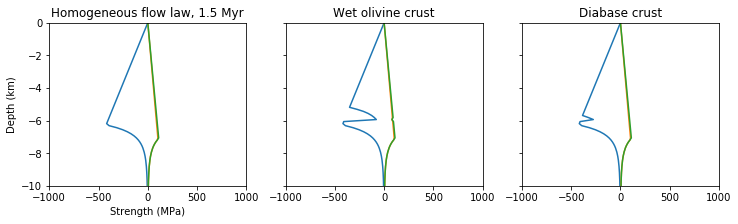

In [8]:
age = 1.5
fig, axes = plt.subplots(nrows=1,ncols=3,sharey='all',sharex='all',figsize=(12.0, 3.0))
# constant flow law
mod_flags = {
    'tesw': 0,
    'flow': 0
}
compute_yse(age,mod_flags)
z,temp_a,pressure,ys_t_homo,ys_c_homo,ys_sh_homo = read_yse_data('out.temp')
plot_YSE(axes[0],ys_c_homo,ys_t_homo,ys_sh_homo,z)
axes[0].set_xlabel('Strength (MPa)')
axes[0].set_ylabel('Depth (km)')
axes[0].set_title('Homogeneous flow law, 1.5 Myr')
axes[0].set_ylim(-10, 0)

# wet olivine crust
mod_flags = {
    'tesw': 0,
    'flow': 1
}
compute_yse(age,mod_flags)
z,temp_a,pressure,ys_t_wet,ys_c_wet,ys_sh_wet = read_yse_data('out.temp')
plot_YSE(axes[1],ys_c_wet,ys_t_wet,ys_sh_wet,z)
axes[1].set_title('Wet olivine crust')
axes[1].set_ylim(-10, 0)

# diabase crust
mod_flags = {
    'tesw': 0,
    'flow': 2
}
compute_yse(age,mod_flags)
z,temp_a,pressure,ys_t_dia,ys_c_dia,ys_sh_dia = read_yse_data('out.temp')
plot_YSE(axes[2],ys_c_dia,ys_t_dia,ys_sh_dia,z)
axes[2].set_title('Diabase crust')
axes[2].set_ylim(-10, 0)

#plt.savefig('flow-laws.pdf', bbox_inches='tight')


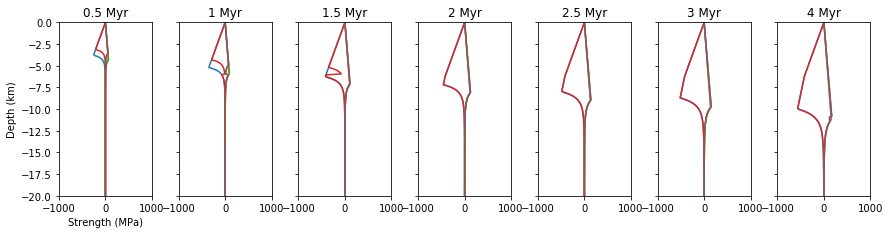

In [10]:
# list of ages to drive the loop
ages = [0.5, 1, 1.5, 2, 2.5, 3, 4]
n = len(ages)

i = 0
# prepare plotting axes
fig_ystr, axes = plt.subplots(nrows=1,ncols=n,sharey='all',sharex='all',figsize=(12.0, 3.0))
fig_ystr.tight_layout()

# initialize integrated strength array
strength_dry = np.zeros((n,1))
strength_wet = np.zeros((n,1))

# define flags for YSE model
dry_flags = {
    'tesw': 0,
    'flow': 0
}
wet_flags = {
    'tesw': 0,
    'flow': 1
}

for age in ages:
    compute_yse(age,dry_flags)
    z,temp_dry,pressure,ystr_tension_dry,ystr_compress_dry,ystr_sh_dry = read_yse_data('out.temp')
    
    compute_yse(age,wet_flags)
    z,temp_wet,pressure,ystr_tension_wet,ystr_compress_wet,ystr_sh_wet = read_yse_data('out.temp')
    #--------------------------------------
    # plot yse
    plot_YSE(axes[i],ystr_compress_dry,ystr_tension_dry,ystr_sh_dry,z)
    plot_YSE(axes[i],ystr_compress_wet,ystr_tension_wet,ystr_sh_wet,z)

    axes[i].set_title(str(age) + " Myr")
    
    if i == 0:
        axes[i].set_xlabel('Strength (MPa)')
        axes[i].set_ylabel('Depth (km)')
        
    # integrated strength in shear
    strength_dry[i] = np.trapz((ystr_sh_dry)*1e6,-1*z*1e3);
    strength_wet[i] = np.trapz((ystr_sh_wet)*1e6,-1*z*1e3);
    
    i+=1
#plt.savefig('flow-laws-time.pdf', bbox_inches='tight')

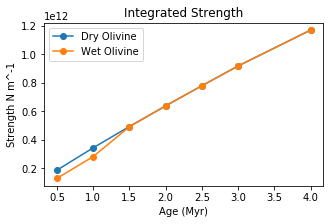

In [11]:
fig_str, ax_str = plt.subplots(figsize=(5.0, 3.0))
ax_str.plot(ages,strength_dry,'o-',label='Dry Olivine')
ax_str.plot(ages,strength_wet,'o-',label='Wet Olivine')

ax_str.legend()

ax_str.set_xlabel('Age (Myr)');
ax_str.set_ylabel('Strength N m^-1');
ax_str.set_title('Integrated Strength')
plt.savefig('flow-laws-strength.png', bbox_inches='tight')

There's something interesting here-- the snapshot at 1.5 Myr shows a weak zone in the lower crust for the alternative flow laws. A slightly different flow law results in this "jelly-sandwich" type of model for young lithosphere. Now, is there good reason for using one of these flow laws?

## Thermal models
The temperature of the material is of great importance in evaluating the yield strength. Since we're concerned with young oceanic lithosphere, we need a model for the cooling of the material.

For more discussion on thermal models, refer to the jupyter notebook in the 'src/thermal' directory.

### Plate cooling model [Parsons and Sclater, 19??]

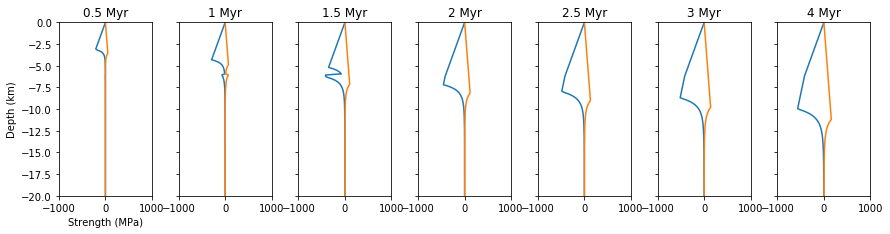

In [16]:
# list of ages to drive the loop
ages = [0.5, 1, 1.5, 2, 2.5, 3, 4]
n = len(ages)

i = 0
# prepare plotting axes
fig_ystr, axes = plt.subplots(nrows=1,ncols=n,sharey='all',sharex='all',figsize=(12.0, 3.0))
fig_ystr.tight_layout()
# initialize integrated strength array
strength_plate = np.zeros((n,1))
# define flags for YSE model
mod_flags = {
    'tesw': 0
}

for age in ages:
    compute_yse(age,mod_flags)
    z,temp_plate,pressure,ystr_tension_plate,ystr_compress_plate = read_yse_data('out.temp')
    #--------------------------------------
    # plot yse
    plot_YSE(axes[i],ystr_compress_plate,ystr_tension_plate,z)
    axes[i].set_title(str(age) + " Myr")
    
    if i == 0:
        axes[i].set_xlabel('Strength (MPa)')
        axes[i].set_ylabel('Depth (km)')

    #--------------------------------------
    # integrated strength in tension
    strength_plate[i] = np.trapz((ystr_tension_plate)*1e6,-1*z*1e3);
    
    i+=1
    
plt.savefig('pl8-yse.pdf', bbox_inches='tight')

### The Sleep (1975) thermal model
For very young oceanic crust, the plate model misses some complexities. Firstly, there's no horizontal advection (dependence on spreading rate). Secondly, the axial temperature profile is simply linear. Sleep (1975) presented an analytical solution to mid-ocean ridge cooling that includes horizontal advection and a more complex axial temperature profile.

In [12]:
# list of ages to drive the loop
ages = [0.5, 1, 1.5, 2, 2.5, 3, 4]
n = len(ages)

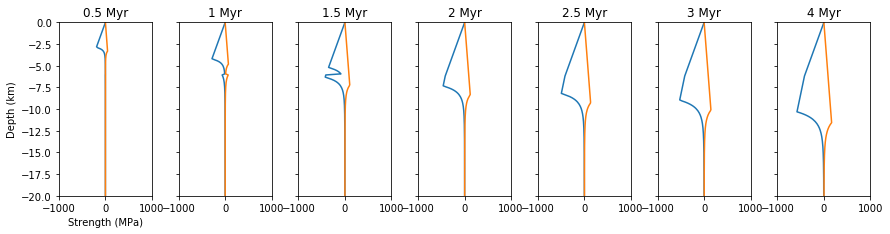

In [17]:
i = 0
# prepare plotting axes
fig_ystr, axes = plt.subplots(nrows=1,ncols=n,sharey='all',sharex='all',figsize=(12.0, 3.0))
fig_ystr.tight_layout()
# initialize integrated strength array
strength_sleep = np.zeros((n,1))
# define flags for YSE model
mod_flags = {
    'tesw': 1,
    'hssw': 0
}

for age in ages:
    compute_yse(age,mod_flags)
    z,temp_a,pressure,ystr_tension_a,ystr_compress_a = read_yse_data('out.temp')
    #--------------------------------------
    # plot yse
    plot_YSE(axes[i],ystr_compress_a,ystr_tension_a,z)
    axes[i].set_title(str(age) + " Myr")
    
    if i == 0:
        axes[i].set_xlabel('Strength (MPa)')
        axes[i].set_ylabel('Depth (km)')
        
    #--------------------------------------
    # integrated strength in tension
    strength_sleep[i] = np.trapz((ystr_tension_a)*1e6,-1*z*1e3);
    
    i+=1
    
plt.savefig('sleep-yse.pdf', bbox_inches='tight')

Let's also plot the integrated strength as a function of age.

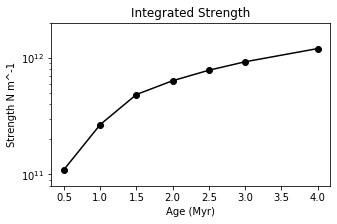

In [20]:
fig_str, ax_str = plt.subplots(figsize=(5.0, 3.0))
ax_str.semilogy(ages,strength_sleep,'ko-')
ax_str.set_ylim(0.8e11, 2e12);
ax_str.set_xlabel('Age (Myr)');
ax_str.set_ylabel('Strength N m^-1');
ax_str.set_title('Integrated Strength')
plt.show()

### A slightly modified thermal model, Morton and Sleep (1985)
How can we model hydrothermal cooling of the young oceanic crust? The intuitive way might be to prescribe the crust a different thermal conductivity, but this approach would prevent us from using an analytical model. Some studies have used a finite element method approach and applied a variable thermal conductivity. The Morton and Sleep (1985) approach uses point source heat sinks in the crust to simulate added cooling of hydrothermal circulation. The benefits: an analytical solution. The downsides? The distribution of the point sources is basically ad hoc.

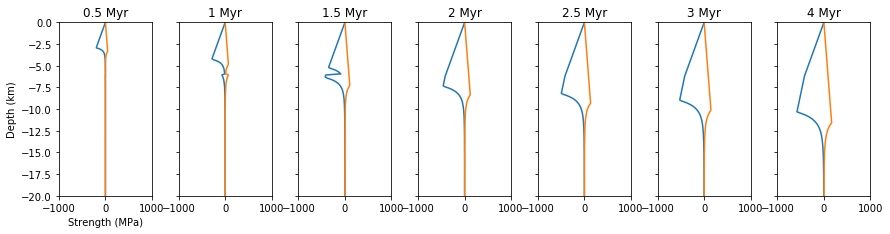

In [21]:
i = 0
# prepare plotting axes
fig_ystr, axes = plt.subplots(nrows=1,ncols=n,sharey='all',sharex='all',figsize=(12.0, 3.0))
fig_ystr.tight_layout()

# initialize integrated strength array
strength_mod = np.zeros((n,1))
# define flags for YSE model
mod_flags = {
    'tesw': 1,
    'hssw': 1
}

for age in ages:
    compute_yse(age,mod_flags)
    z,temp_b,pressure,ystr_tension_b,ystr_compress_b = read_yse_data('out.temp')
    #--------------------------------------
    # plot yse
    plot_YSE(axes[i],ystr_compress_b,ystr_tension_b,z)
    axes[i].set_title(str(age) + " Myr")
    
    if i == 0:
        axes[i].set_xlabel('Strength (MPa)')
        axes[i].set_ylabel('Depth (km)')
        
    #--------------------------------------
    # integrated strength
    strength_mod[i] = np.trapz((ystr_tension_b)*1e6,-1*z*1e3);
    
    i+=1
    
plt.savefig('ms-yse.pdf', bbox_inches='tight')

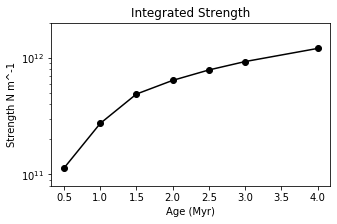

In [24]:
fig_str, ax_str = plt.subplots(figsize=(5.0, 3.0))
ax_str.semilogy(ages,strength_mod,'ko-')
ax_str.set_ylim(0.8e11, 2e12);
ax_str.set_xlabel('Age (Myr)');
ax_str.set_ylabel('Strength N m^-1');
ax_str.set_title('Integrated Strength')
plt.show()

Of course, by eye, there's not much of a difference. But let's examine the results of these models more closely.

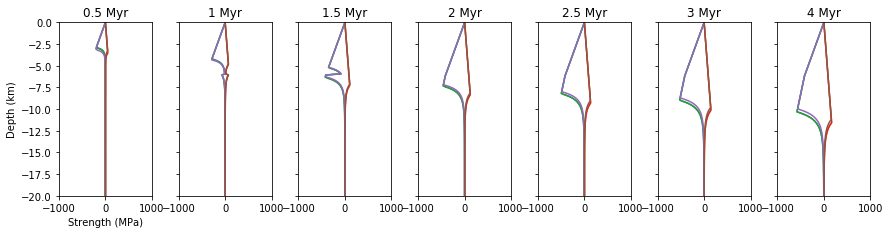

In [25]:
i = 0

# prepare plotting axes
fig_ystr, axes = plt.subplots(nrows=1,ncols=n,sharey='all',sharex='all',figsize=(12.0, 3.0))
fig_ystr.tight_layout()
# initialize integrated strength array
strength_a = np.zeros((n,1))
strength_b = np.zeros((n,1))
strength_plate = np.zeros((n,1))
# define flags for YSE model
plate_flags = {
    'tesw': 0
}
sleep_flags = {
    'tesw': 1,
    'hssw': 0
}

mod_flags = {
    'tesw': 1,
    'hssw': 1
}


for age in ages:
    compute_yse(age,plate_flags)
    z,temp_a,pressure,ystr_tension_plate,ystr_compress_plate = read_yse_data('out.temp')
    
    compute_yse(age,sleep_flags)
    z,temp_a,pressure,ystr_tension_a,ystr_compress_a = read_yse_data('out.temp')
    
    compute_yse(age,mod_flags)
    z,temp_b,pressure,ystr_tension_b,ystr_compress_b = read_yse_data('out.temp')
    
    #--------------------------------------
    # plot yse
    plot_YSE(axes[i],ystr_compress_a,ystr_tension_a,z)
    plot_YSE(axes[i],ystr_compress_b,ystr_tension_b,z)
    plot_YSE(axes[i],ystr_compress_plate,ystr_tension_plate,z)

    axes[i].set_title(str(age) + " Myr")
    
    if i == 0:
        axes[i].set_xlabel('Strength (MPa)')
        axes[i].set_ylabel('Depth (km)')
        

    #--------------------------------------
    # integrated strength
    strength_a[i] = np.trapz((ystr_tension_a)*1e6,-1*z*1e3);
    strength_b[i] = np.trapz((ystr_tension_b)*1e6,-1*z*1e3);
    strength_plate[i] = np.trapz((ystr_tension_plate)*1e6,-1*z*1e3);
    
    i+=1

Plate model v Sleep: 11.21% difference
Sleep v M&S.         2.90% difference

Plate model v Sleep: 0.28% difference
Sleep v M&S.         2.29% difference

Plate model v Sleep: 4.65% difference
Sleep v M&S.         0.89% difference

Plate model v Sleep: 5.96% difference
Sleep v M&S.         0.64% difference

Plate model v Sleep: 6.64% difference
Sleep v M&S.         0.54% difference

Plate model v Sleep: 6.92% difference
Sleep v M&S.         0.43% difference

Plate model v Sleep: 7.09% difference
Sleep v M&S.         0.31% difference



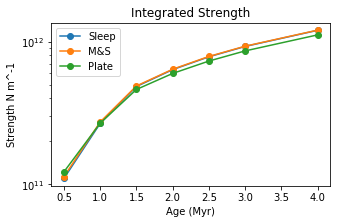

In [27]:
for i in range(n):
    stren_diff = abs(strength_a[i] - strength_b[i])/strength_a[i]
    plate_diff = abs(strength_a[i] - strength_plate[i])/strength_a[i]
    
    print('Plate model v Sleep: {:4.2%} difference'.format(plate_diff[0]))
    print('Sleep v M&S.         {:4.2%} difference\n'.format(stren_diff[0]))
    
fig_str, ax_str = plt.subplots(figsize=(5.0, 3.0))
ax_str.semilogy(ages,strength_a,'o-',label='Sleep')
ax_str.semilogy(ages,strength_b,'o-',label='M&S')
ax_str.semilogy(ages,strength_plate,'o-',label='Plate')

ax_str.legend()
#ax_str.set_ylim(0.2e12, 1e13);
ax_str.set_xlabel('Age (Myr)');
ax_str.set_ylabel('Strength N m^-1');
ax_str.set_title('Integrated Strength')

plt.savefig('compare-3-strength.png', bbox_inches='tight')

For a 2 cm/yr half spreading rate, the plate cooling and Sleep cooling model have about a 10% discrepancy at 0.5 Myr, and the difference is greater at younger ages (but so is our knowledge of the temperature). The plate cooling model is initially stronger, but the two quickly converge. The Sleep and M&S models also differ at young ages, and that's to be expected because that's where the heat sinks are. Overall, the variability expressed by these models is not that great for our purposes.